**Maestría en Inteligencia Artificial Aplicada**

**Curso: Proyecto Integrador**

**Tecnológico de Monterrey**

**Equipo 9**

**Jorge Luis Arroyo Chavelas (A01793023)**

# Avance 3. Modelo Base

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
       In this notebook, we will develop a classification model that processes raw text to determine whether it pertains to Education, Experience, or Skills. The model will be trained using pre-classified resume data and constructed using the BERT transformer model. Our goal is to achieve a level of generalization that allows the model's application to both: resumes and job positions.
    </p>
    <p>
        By successfully categorizing raw text into these three categories for both employers and job seekers, we aim to streamline the comparison process to generate a matching score by the direct comparisson of these fields.
    </p>
    <p>
        To start, let's set up our lab for experimentation by calling some libraries:
    </p>
</div>

In [1]:
## Env and interface libraries
import os
from dotenv import load_dotenv
from tqdm.auto import tqdm

## Data call and manipulation
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

## NLP
import re

## ML/DL
import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Call env variables
load_dotenv()

# Select torch device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

/Users/dataalchemist/Documents/Tec/Proyecto Integrador/IRPO/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dataalchemist/Documents/Tec/Proyecto Integrador/IRPO/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Data

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
    We will refer to the dataset comprising various pre-classified resumes in our database as the model data. This dataset is organized into the specific categories we aim to  train our model on.
    </p>
</div>

In [2]:
## Choose if you have access to postgres DB or not.
DB_ACCESS = True

## Call data - either from DB or from csv file
if DB_ACCESS:
    DATABASE_URL = os.getenv("DATABASE_URL", "")
    SQL_QUERY = """
        SELECT  resource_id
                , resource_text
                , resource_skills
                , resource_experience
                , resource_education
        FROM    public.IRPO_RESOURCE;                                
        """
    engine = create_engine(DATABASE_URL)
    raw_data = pd.read_sql(text(SQL_QUERY), engine.connect())
    raw_data.to_csv('./extract.csv', index=False)
else: 
    raw_data = pd.read_csv('extract.csv')

# Visualize data
print(f"dataframe of shape: {raw_data.shape}")
display(raw_data.head(2))

dataframe of shape: (3566, 5)


,resource_id,resource_text,resource_skills,resource_experience,resource_education
0,1,"Jessica Claire\nMontgomery Street, San Francis...","Machine learning,Statistical Analysis,Data Min...","Work History\nData Scientist, 06/2019 - 12/202...",Education\nMaster of Science: Computer Science...
1,2,"Jessica Claire\nMontgomery Street, San Francis...",Python; Java; Spring; Hibernate; SQL; JavaScri...,"Work Experience\nPython Developer Intern, 07/2...",Education and Training\nMaster of Science: Com...


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Our dataset currently comprises comprehensive sections that span multiple lines, potentially complicating the training process. To mitigate this, we plan to deconstruct these sections into discrete lines of text, eschewing the use of entire sections. We will then segment the data from each distinct section and enhance it with an additional column that denotes its source. Consequently, this approach will yield a structured format where each individual text line is paired with a column that delineates its category.
    </p>
</div>

In [3]:
# Function to extract the lines
def extract_lines(df, col):
    """
    Extracts lines from a DataFrame column.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to extract lines from.
        col (str): The name of the column containing the text.

    Returns:
        pd.DataFrame: A new DataFrame with one column named 'text_line' containing the extracted lines.
    """

    return (
        df[col]
        .str.split('\n', expand=True)
        .stack()
        .reset_index(level=1, drop=True)
        .rename('text_line')
    )

# Extract the lines of each category to form a new dataframe
skills = extract_lines(raw_data, 'resource_skills')
education = extract_lines(raw_data, 'resource_education')
experience = extract_lines(raw_data, 'resource_experience')

# Creating a DataFrame from each Series and adding a feature column
df_skills = pd.DataFrame({'text_line': skills}).assign(feature='skills')
df_education = pd.DataFrame({'text_line': education}).assign(feature='education')
df_experience = pd.DataFrame({'text_line': experience}).assign(feature='experience')

# Concatenating all DataFrames into one
melt_df = pd.concat([df_skills, df_education, df_experience], ignore_index=True)

# Displaying the melt DataFrame
melt_df

,text_line,feature
0,"Machine learning,Statistical Analysis,Data Mining",skills
1,"· Python, R, SQL.",skills
2,"· Keras, NumPy, Pandas, Scikit-learn, NLTK, Sp...",skills
3,"Development Tools: Anaconda, PyCharm, Spyder, ...",skills
4,"Theoretical Competencies: AGILE, Scrum, Algori...",skills
...,...,...
225709,Kansas State University Foundation,experience
225710,Initiated engineering notion and wonder in stu...,experience
225711,Supervised student to design and implement ele...,experience
225712,Performed embedded microcontroller system desi...,experience


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To streamline our dataset by minimizing special characters like bullet points, which are prevalent in resumes, we will undertake a cleaning process. This process will retain only alphanumeric characters and standard punctuation marks. For uniformity, all text will be converted to lowercase. However, we will refrain from removing stopwords or applying lemmatization techniques, as our objective is to leverage a transformer model that could utilize these words for contextual understanding.
    </p>
</div>

In [4]:
# Cleaning function
def clean_text(text):
    """
    Cleans text by removing special characters, keeping only alphanumeric 
    characters in lowercase, common punctuation, and whitespace.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """

    # Keeping text characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9,.!?;:\-\s\'\"]+', '', text).lower()

    # Removing extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# Applying the cleaning function to generate a new column with cleaned text
melt_df['text_line'] = melt_df['text_line'].apply(clean_text)

# Drop empty lines
clean_df =  melt_df[melt_df['text_line'] != '']

# Displaying the DataFrame
clean_df

,text_line,feature
0,"machine learning,statistical analysis,data mining",skills
1,"python, r, sql.",skills
2,"keras, numpy, pandas, scikit-learn, nltk, spac...",skills
3,"development tools: anaconda, pycharm, spyder, ...",skills
4,"theoretical competencies: agile, scrum, algori...",skills
...,...,...
225709,kansas state university foundation,experience
225710,initiated engineering notion and wonder in stu...,experience
225711,supervised student to design and implement ele...,experience
225712,performed embedded microcontroller system desi...,experience


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Next, we will implement One Hot Encoding for our labels of interest. This encoding technique will assign a '1' to the appropriate label for each line of text and '0' to all others. This approach facilitates the input of data into our models and enhances the training and evaluation processes. By adopting One Hot Encoding, we can develop a model that outputs a probability vector. This vector can be more effectively compared to the ground truth, allowing for a more precise arithmetic evaluation of a loss function.
    </p>
</div>

In [5]:
# One-hot encoding
ohe_df = pd.get_dummies(clean_df,
                        columns=['feature'],
                        dtype=float, 
                        prefix='', 
                        prefix_sep='')
ohe_df = ohe_df.rename(columns={'text_line': 'text'})


# Dataframe creation (balanced)
model_df = pd.concat([
    ohe_df[ohe_df['education'] == 1].sample(300, random_state=42),
    ohe_df[ohe_df['experience'] == 1].sample(300, random_state=42),
    ohe_df[ohe_df['skills'] == 1].sample(300, random_state=42)
]).reset_index(drop=True)

model_df

,text,education,experience,skills
0,"devry university, seven hills, oh",1.0,0.0,0.0
1,pharmaceutical sciences,1.0,0.0,0.0
2,business communications,1.0,0.0,0.0
3,"gpa: magna cum laude, dean's list, tempe diabl...",1.0,0.0,0.0
4,industrial design and cad engineering,1.0,0.0,0.0
...,...,...,...,...
895,strategic thinker,0.0,0.0,1.0
896,team building and motivation,0.0,0.0,1.0
897,technical document creation,0.0,0.0,1.0
898,computer diagnostics and repair,0.0,0.0,1.0


## Classification Model

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To interface effectively with our model, we must encode our text data, converting raw strings into a vectorized format suited for neural network analysis. To achieve this, we'll encapsulate the encoding process within a function utilizing the BERT Tokenizer. This function will manage both the tokenization and numerical conversion of the text, as well as the creation of attention masks in tensors.
    </p>
</div>

In [6]:
# Prprocess data
def preprocess_data(texts, tokenizer):
    """
    Tokenizes text data and converts it to tensors.

    Args:
        texts (list): A list of strings containing the text to be tokenized.

    Returns:
        dict: A dictionary containing input ids, attention masks, and token type ids as tensors.
    """
    # Tokenize all texts and map the tokens to their word IDs
    encoded_batch = tokenizer.batch_encode_plus(texts, 
                                                add_special_tokens=True, 
                                                max_length=256, 
                                                padding=True, 
                                                truncation=True, 
                                                return_attention_mask=True, 
                                                return_tensors='pt')
    
    # Convert the lists into tensors
    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']
    token_type_ids = encoded_batch['token_type_ids']
    
    return {
        'input_ids': input_ids, 
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids
    }

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        We will now develop a CustomDataset class designed to handle both encodings and labels, which are essential components for training our model.
    </p>
</div>

In [7]:
# Dataset Class
class CustomDataset(Dataset):
    """
    Create a custom PyTorch Dataset used for loading data into the model.

    Args:
        encodings (dict): Dictionary containing encoded text representations.
        labels (list or torch.Tensor): Labels (targets) for each text.
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels).long()

    def __getitem__(self, idx):
        """
        Returns an item from the dataset at the given index.

        Args:
            idx (int): Index position to return.

        Returns:
            dict: Dictionary containing input_ids, attention_mask, token_type_ids, and label.
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx] 
        return item

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.labels)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In our training function, we will utilize a pre-trained <b>BERTForSequenceClassification</b> model, focusing on fine-tuning it specifically for our dataset. This approach allows us to leverage the model's existing knowledge base, adapting it to the nuances of our data for optimal performance.
    </p>
</div>

In [8]:
# Training routine
def train_model(dataloader, model, optimizer, epochs=3):
    """
    Trains the BERT model using the provided dataloader and optimizer.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        model (torch.nn.Module): The BERT model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer used for model training.
        epochs (int, optional): The number of training epochs. Defaults to 3.
    """

    model.train()  # Ensure the model is in training mode

    for epoch in range(epochs):
        total_loss = 0  # Initialize total loss for each epoch

        # Iterate over batches
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            optimizer.zero_grad()  # Clear gradients before each update

            # Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'].view(-1))

            # Backward pass: Compute gradient of the loss with respect to model parameters
            loss = outputs.loss
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Accumulate the training loss
            total_loss += loss.item()

        # Print average loss for the epoch
        print(f"Average loss for epoch {epoch + 1}: {total_loss / len(dataloader)}")

    print("Training complete.")

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Our evaluate_model function, assess the performance of our pre-trained BERT model. The function will output both the average loss and the overall accuracy. The function calculates the predictions by finding the argument with the maximum logit value (using argmax), which corresponds to the most likely label according to the model.
    </p>
</div>


In [9]:
# Evaluation function
def evaluate_model(dataloader, model):
    """
    Evaluates the BERT model using the provided dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation data.
        model: The pre-trained BERT model to be evaluated.
    """

    model.eval() 

    total_loss = 0
    correct_predictions = 0

    with no_grad():
        for batch in dataloader:
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'])

            predictions = outputs.logits.argmax(dim=-1)
            total_loss += outputs.loss.item()
            correct_predictions += (predictions == batch['labels']).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    print(f"Validation Loss: {avg_loss}")
    print(f"Validation Accuracy: {accuracy}")


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Up next, we will define an strategy using the above functions and classes to do a training of our model.
    </p>
</div>


In [10]:
# Sampled data
sampled_df = model_df#.sample(n=200)

# Split into training and testing datasets
train_df, test_df = train_test_split(sampled_df, test_size=0.5)

# Extract texts and labels for training
train_texts = train_df['text'].tolist()
train_labels = train_df[['education', 'experience', 'skills']].idxmax(axis=1).astype('category').cat.codes

# Initialize the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Preprocess the training texts
train_encodings = preprocess_data(train_texts, tokenizer)

# Create the training dataset and dataloader
train_dataset = CustomDataset(train_encodings, train_labels.tolist())
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/dataalchemist/Documents/Tec/Proyecto Integrador/IRPO/venv/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Here we strart the trainning of our model with our loaded data.
    </p>
</div>

In [11]:
train_model(train_dataloader, model, optimizer, epochs=8)

Epoch 1/8:   0%|          | 0/29 [00:00<?, ?batch/s]/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_52735/3975903960.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1/8: 100%|██████████| 29/29 [02:12<00:00,  4.59s/batch]


Average loss for epoch 1: 0.666920464614342


Epoch 2/8: 100%|██████████| 29/29 [02:15<00:00,  4.66s/batch]


Average loss for epoch 2: 0.2247587018485727


Epoch 3/8: 100%|██████████| 29/29 [02:14<00:00,  4.64s/batch]


Average loss for epoch 3: 0.13892086023657485


Epoch 4/8: 100%|██████████| 29/29 [02:20<00:00,  4.86s/batch]


Average loss for epoch 4: 0.04275043000435007


Epoch 5/8: 100%|██████████| 29/29 [02:23<00:00,  4.94s/batch]


Average loss for epoch 5: 0.018190728966146708


Epoch 6/8: 100%|██████████| 29/29 [02:16<00:00,  4.70s/batch]


Average loss for epoch 6: 0.005090057143363459


Epoch 7/8: 100%|██████████| 29/29 [02:25<00:00,  5.03s/batch]


Average loss for epoch 7: 0.003997064179516044


Epoch 8/8: 100%|██████████| 29/29 [02:18<00:00,  4.79s/batch]

Average loss for epoch 8: 0.0030519628198817372
Training complete.


## Testing Model

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        With a trained model, we can start meassuring it's effectivness, for that let's first define a prediction function.
    </p>
</div>

In [12]:
def predict(text, model, tokenizer):
    """
    Predicts the category of a given text using the trained BERT model.

    Args:
        text (str): The input text to classify.
        model: The trained BERT model.
        tokenizer: The tokenizer used for the BERT model.

    Returns:
        str: The predicted category ('education', 'experience', or 'skills').
    """
    # Prepare the text for the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt")

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the prediction
    logits = outputs.logits
    prediction = logits.argmax(-1).item()

    # Map the prediction to the corresponding category
    categories = ['education', 'experience', 'skills']
    predicted_category = categories[prediction]

    return predicted_category


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Let's apply our prediction into some text exampples.
    </p>
</div>

In [13]:
example_texts = [
    "Master of Science in Computer Science from Stanford University",
    "Developed a sales forecasting model with Python",
    "Proficient in Microsoft Excel, PowerPoint, and Word"
]

for text in example_texts:
    prediction = predict(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Category: {prediction}\n")


Text: Master of Science in Computer Science from Stanford University
Predicted Category: education

Text: Developed a sales forecasting model with Python
Predicted Category: experience

Text: Proficient in Microsoft Excel, PowerPoint, and Word
Predicted Category: skills



<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        We can also use the same function with dataframes of real data to measure the effectivenes of it. For this part we will use some of the unseen data to do a validation test.
    </p>
</div>

In [14]:
# Compute the true labels by identifying the max value in the one-hot encoded columns
test_df['true_label'] = test_df[['education', 'experience', 'skills']].idxmax(axis=1)

# Use the predict function to generate predictions for each row in the DataFrame
test_df['predicted_label'] = test_df['text'].apply(lambda x: predict(x, model, tokenizer))

test_df

,text,education,experience,skills,true_label,predicted_label
854,excellent problem solving skills,0.0,0.0,1.0,skills,skills
614,"databases: oracle 8i, 9i, 10g, 11g, 12c, ms sq...",0.0,0.0,1.0,skills,skills
187,1984,1.0,0.0,0.0,education,education
71,education,1.0,0.0,0.0,education,education
737,problem-solving and analysis skills,0.0,0.0,1.0,skills,skills
...,...,...,...,...,...,...
27,"wemmel, belgium 061999",1.0,0.0,0.0,education,education
408,"olympia, wa 012016 - 092016",0.0,1.0,0.0,experience,experience
303,reviewed and provided comments and advice with...,0.0,1.0,0.0,experience,experience
479,research technician ii,0.0,1.0,0.0,experience,education


Accuracy: 0.8889


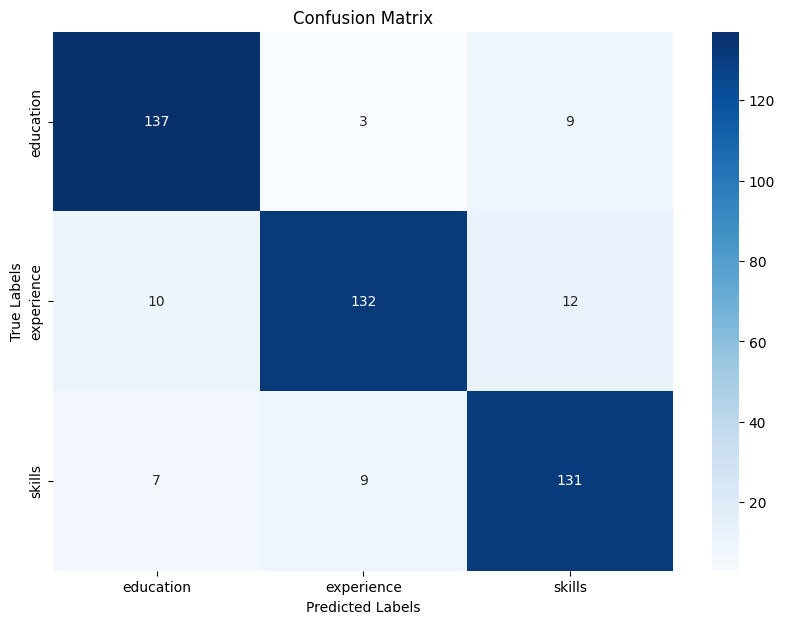

In [15]:
# Extract true labels and predicted labels
true_labels = test_df['true_label'].tolist()
predicted_labels = test_df['predicted_label'].tolist()

# Calculate the confusion matrix and accuracy
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print accuracy
print(f"Accuracy: {accuracy:.4f}")

# Categories
categories = ['education', 'experience', 'skills']

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Conclussions

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The classification model we developed has successfully achieved an accuracy of 88.89% in identifying text as pertaining to Education, Experience, or Skills. This performance aligns with our initial goal to create a model capable of effectively categorizing resume data, using the BERT transformer model to ensure its applicability across both resumes and job descriptions.
    </p>
    <p>
        With its reliable categorization of text into these critical areas, the model sets the stage for a more straightforward comparison process. This achievement moves us closer to our ultimate goal of creating a system that can generate accurate matching scores by comparing the essential fields of qualifications, experiences, and skills. The results we've seen provide a solid foundation for addressing the scoring challenge, marking a key step forward in our efforts to enhance the job matching and recruitment process.
    </p>
</div>


====== END OF ACTIVITY ======